In [9]:
%matplotlib inline

from os.path import join as opj

import os
import json

from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths, MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

In [17]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

task_list = ['socialcomparison']

fwhm = [4, 8]

with open('/data/ds000213/task-socialcomparison_bold.json', 'rt') as fp: #fp? variable name?
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

#Isometric resample of functional images to voxel size (in mm)
iso_size = 4

In [18]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

In [19]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

In [24]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'func',
                'sub-{subject_id}_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000213'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [25]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),

                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

190208-07:19:37,446 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


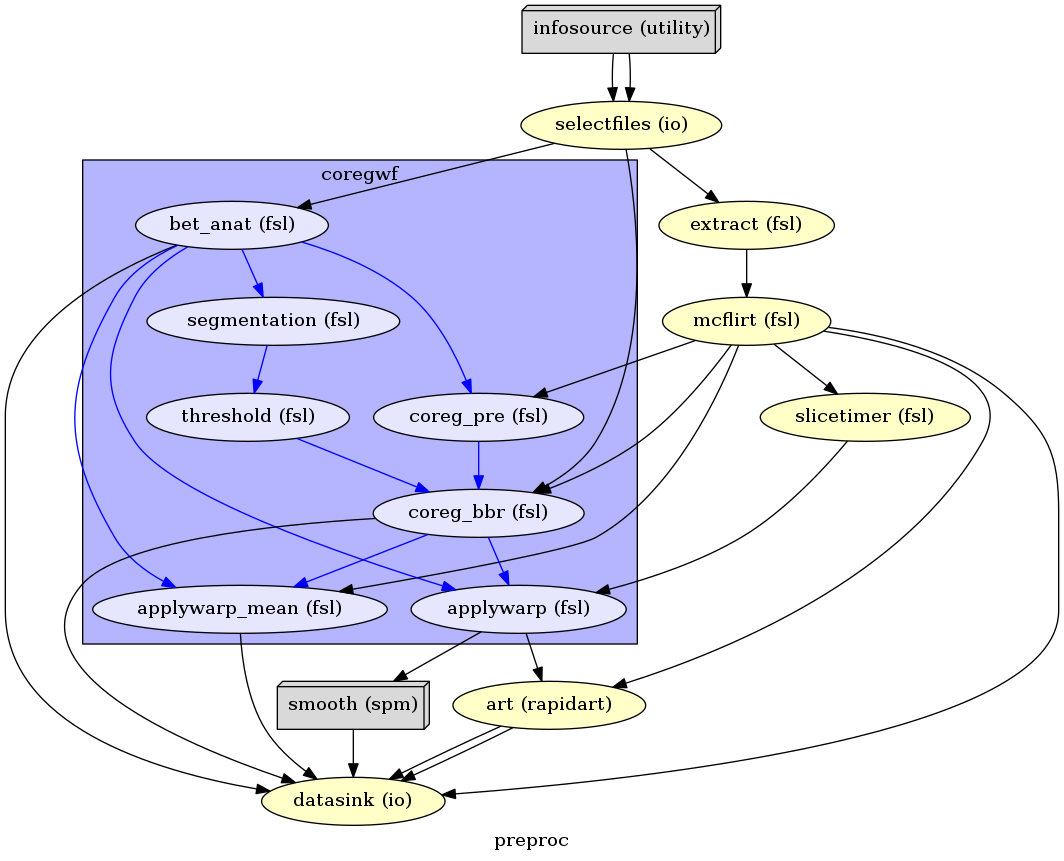

In [26]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

In [27]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

190208-07:19:38,258 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
190208-07:19:38,499 nipype.workflow INFO:
	 Running in parallel.
190208-07:19:38,506 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 5.24/5.24, Free processors: 4/4.
190208-07:19:38,574 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_10_task_name_socialcomparison/selectfiles".190208-07:19:38,587 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_08_task_name_socialcomparison/selectfiles".190208-07:19:38,583 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_09_task_name_socialcomparison/selectfiles".190208-07:19:38,590 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_07_task_name_socialcomparison/select

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(config.get("execution", "matplotlib_backend"))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:398: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(config.get("execution", "matplotlib_backend"))


190208-07:33:31,73 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
190208-07:33:31,585 nipype.workflow INFO:
	 [Job 13] Completed (preproc.art).
190208-07:33:31,590 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 4.64/5.24, Free processors: 1/4.
                     Currently running:
                       * preproc.smooth
                       * preproc.mcflirt
                       * preproc.coregwf.coreg_bbr
190208-07:33:31,817 nipype.workflow INFO:
	 [Node] Setting-up "preproc.datasink" in "/output/workingdir/preproc/_subject_id_10_task_name_socialcomparison/_fwhm_8/datasink".
190208-07:33:31,863 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
190208-07:33:31,903 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_10_task_name_socialcomparison/sub-10_task-socialcomparison_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-10/task-socialcomparison/sub-10_task-socialcomparison_bold

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(config.get("execution", "matplotlib_backend"))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:398: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(config.get("execution", "matplotlib_backend"))


190208-07:34:25,647 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 4.44/5.24, Free processors: 0/4.
                     Currently running:
                       * preproc.art
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.coreg_bbr
190208-07:34:26,98 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
190208-07:34:27,648 nipype.workflow INFO:
	 [Job 29] Completed (preproc.art).
190208-07:34:27,651 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 8 jobs ready. Free memory (GB): 4.64/5.24, Free processors: 1/4.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.coreg_bbr
190208-07:34:27,751 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.coreg_pre" in "/output/workingdir/preproc/coregwf/_subject_id_07_task_name_socialcomparison/coreg_pre".
19

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(config.get("execution", "matplotlib_backend"))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:398: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(config.get("execution", "matplotlib_backend"))


190208-07:36:01,750 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 7 jobs ready. Free memory (GB): 4.44/5.24, Free processors: 0/4.
                     Currently running:
                       * preproc.art
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.coreg_bbr
190208-07:36:01,954 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
190208-07:36:03,753 nipype.workflow INFO:
	 [Job 45] Completed (preproc.art).
190208-07:36:03,759 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 4.64/5.24, Free processors: 1/4.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.coreg_bbr
190208-07:36:03,894 nipype.workflow INFO:
	 [Node] Setting-up "preproc.slicetimer" in "/output/workingdir/preproc/_subject_id_07_task_name_socialcomparison/slicetimer".
190208-07:36:03

In [28]:
!tree /output/datasink/preproc

/output/datasink/preproc
├── sub-01
│   ├── task-calorieimage_run-03
│   │   ├── art.sub-01_task-calorieimage_run-03_bold_outliers.txt
│   │   ├── fwhm-4_ssub-01_task-calorieimage_run-03_bold.nii
│   │   ├── fwhm-8_ssub-01_task-calorieimage_run-03_bold.nii
│   │   ├── plot.sub-01_task-calorieimage_run-03_bold.svg
│   │   ├── sub-01_T1w_brain.nii.gz
│   │   ├── sub-01_task-calorieimage_run-03_bold_mean.mat
│   │   ├── sub-01_task-calorieimage_run-03_bold_mean.nii
│   │   ├── sub-01_task-calorieimage_run-03_bold_mean.nii.gz
│   │   └── sub-01_task-calorieimage_run-03_bold.par
│   └── task-socialcomparison
│       ├── art.sub-01_task-socialcomparison_bold_outliers.txt
│       ├── fwhm-4_ssub-01_task-socialcomparison_bold.nii
│       ├── fwhm-8_ssub-01_task-socialcomparison_bold.nii
│       ├── plot.sub-01_task-socialcomparison_bold.svg
│       ├── sub-01_T1w_brain.nii.gz
│       ├── sub-01_task-socialcomparison_bold_mean.mat
│       ├── sub-01_task-socialcomparison_bold_mean.nii.gz
│     

In [29]:
from nilearn import image, plotting
%matplotlib inline
out_path = '/output/datasink/preproc/sub-01/task-socialcomparison'

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


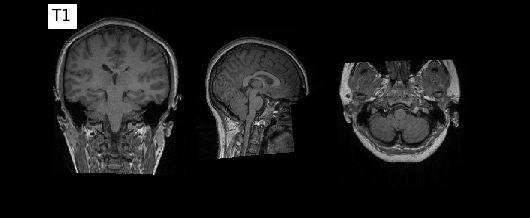

In [30]:
plotting.plot_epi(
    '/data/ds000213/sub-01/anat/sub-01_T1w.nii.gz',
    title = "T1", display_mode = 'ortho', annotate = False, draw_cross = False, cmap = 'gray'); #epi-echo planar imaging?

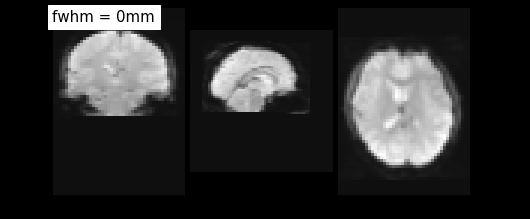

In [31]:
plotting.plot_epi(opj(out_path, 'sub-01_task-socialcomparison_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

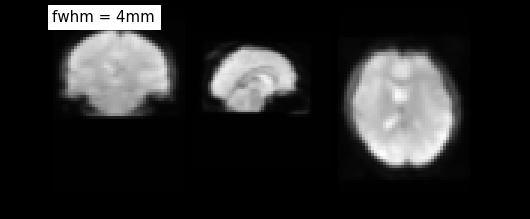

In [32]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-4_ssub-01_task-socialcomparison_bold.nii')),
                  title="fwhm = 4mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

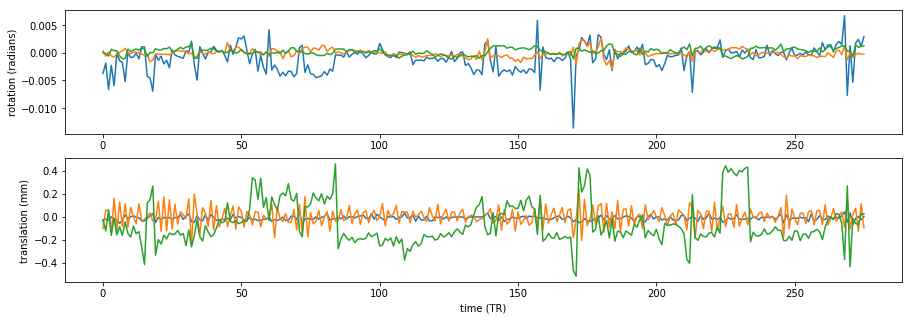

In [33]:
import numpy as np
import pylab as plt

par = np.loadtxt('/output/datasink/preproc/sub-01/task-socialcomparison/sub-01_task-socialcomparison_bold.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)');

Outliers were detected at volumes: 269.0


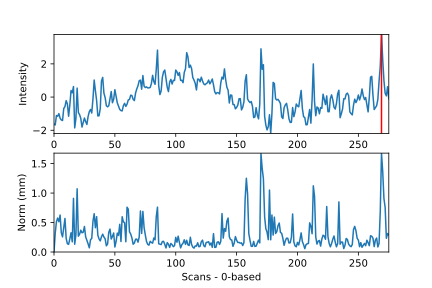

In [34]:
import numpy as np
outlier_ids = np.loadtxt('/output/datasink/preproc/sub-01/task-socialcomparison/art.sub-01_task-socialcomparison_bold_outliers.txt')
print('Outliers were detected at volumes: %s' % outlier_ids)

from IPython.display import SVG
SVG(filename='/output/datasink/preproc/sub-01/task-socialcomparison/plot.sub-01_task-socialcomparison_bold.svg')